# **Final Notebook for the 2022 Code 600 and OSTEM Intern Final Presentations**

This notebook will serve to show all of the code written to produce the plots in Lasata Tuladhar's final and virtual presentation for Code 600 and Office of Science, Technology, Engineering, and Mathematics (OSTEM) interns at NASA Goddard Space Flight Center (GSFC) in Greenbelt, Maryland. This presentation was broadcasted on Microsoft Teams on Tuesday, August 9th, 2022 between 12:30 - 2:30 PM and Wednesday, August 10th, 2022 between 10:00 AM - 4:00 PM. 

## **Candidate:** AD Leonis (TIC 95431305)

Oscillations, or quasi-periodic pulsations (QPPs), are an oscillatory feature found in the decay branch of solar and stellar flares. QPPs travel on magnetic field lines in the star’s atmosphere and show the star’s flaring process. This project originally aimed to survey the flares of low-mass stars to search for these QPPs. This survey was procured by the Transiting Exoplanet Survey Satellite (TESS) at its 20-second cadence. After doing a by-eye search for over 60 K, G, and M type stars, some of the stars were flaring candidates, of which AD Leonis (AD Leo) was one of the best examples.

AD Leo is a low mass, M dwarf star that has a magnitude of 7.036, a mass of 0.4166 solar masses, and a radius of 0.4226 solar radii. More information and parameters on AD Leo can be found here: https://simbad.u-strasbg.fr/simbad/sim-basic?Ident=AD+Leo&submit=SIMBAD+search and here: http://www.exoplanetkyoto.org/exohtml/AD_Leo.html. 

### **Step 1:** Import all necessary libraries.

In [95]:
# !pip install lightkurve
# !pip install numexpr
# !pip install pyodbc
# !pip install emd --ignore-installed llvmlite

import lightkurve as lk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.time import Time

from scipy import signal
from scipy.signal import savgol_filter
from scipy import stats
from scipy.interpolate import UnivariateSpline
from scipy import fftpack

import emd

%matplotlib inline

### **Step 2:** Call the candidate data avaliable in the _lightkurve_ package. Then, check its scatterplot to confirm its status as a flaring candidate.

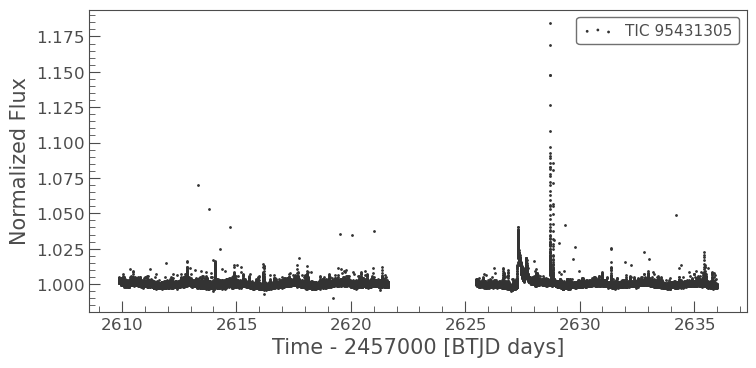

In [6]:
ADL = lk.search_lightcurve('TIC 95431305', mission = 'TESS', author = 'SPOC', sector = 48 , cadence = 20).download()
ADL.normalize().scatter()

Based on the scatterplot, AD Leo is indeed a flaring candidate. There is a clear flare between 2627 - 2628 BTJD, which will eventually become the target flare of interest. 

### **Step 3:** Remove unnecessary parameters from the plot.

The above plot contains NaN values and solar rotation, which should be removed.

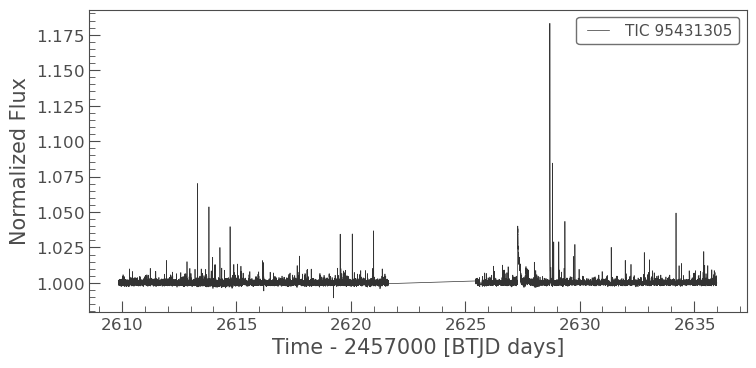

In [8]:
norm_ADL = ADL.normalize().remove_nans()
flat_ADL = norm_ADL.flatten(window_length = 1801)
flat_ADL.plot()

### **Step 4:** Select the target flare of interest.

(2627.25, 2627.6)

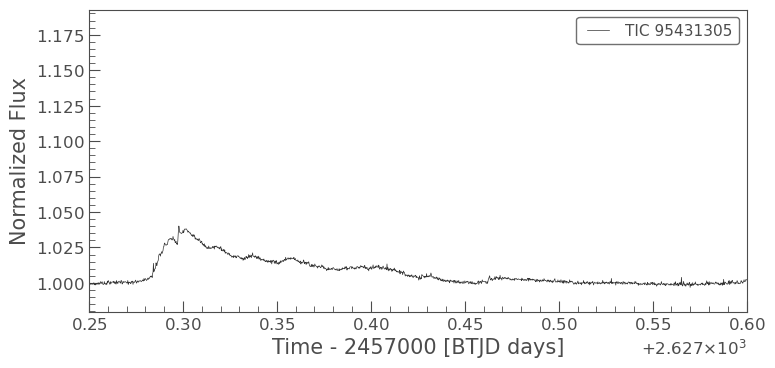

In [10]:
flat_ADL.plot()
plt.xlim(2627.25,2627.6)

Now that the plot is zoomed in, the QPPs are visible in this textbook flare from AD Leo.

### **Step 5:** To extract the analysis region, create a primary time array and check one time object.

In [11]:
ADL.time

<Time object: scale='tdb' format='btjd' value=[2607.93898503 2607.93921652 2607.93944801 ... 2635.99166645 2635.99189793
 2635.9921294 ]>

In [14]:
flat_ADL.time[58000 : 59515]

<Time object: scale='tdb' format='btjd' value=[2627.2500289  2627.25026038 2627.25049187 ... 2627.60003103 2627.60026251
 2627.60049399]>

In [15]:
time_array = np.array(flat_ADL.time[58000 : 59515])
time_array[1]

<Time object: scale='tdb' format='btjd' value=2627.250260384753>

### **Step 6:** Using the _astropy_ package, create an _astropy_ Time Array with the above time object.

In [18]:
t = Time(time_array)
TESS_TIME = t.btjd
TESS_TIME.size

1515

### **Step 7:** Create a new time object that starts at 0 seconds.

In [19]:
t1 = np.arange(start = 0, stop = 30300, step = 20, dtype = int) # stop = flattened size * 20

# Checks
print('t1.SIZE:', t1.size)  
print('t1[1]:', t1[1])  
print('TYPE(t1):', type(t1))  
print('t1:', t1)  

t1.SIZE: 1515
t1[1]: 20
TYPE(t1): <class 'numpy.ndarray'>
t1: [    0    20    40 ... 30240 30260 30280]


In [20]:
flux_array1 = np.array(flat_ADL.flux[58000 : 59515])  # RANGE FOR BOTH FLARES

print(flux_array1.size)
print(type(flux_array1))
print(flux_array1[1])
print("----------------------------------------------------------")
print(flux_array1)

1515
<class 'numpy.ndarray'>
0.9998241184758947
----------------------------------------------------------
[0.99968439 0.99982412 0.99908474 ... 1.00198037 1.00090481 1.00188782]


### **Step 8:** Plot the Time Array (in seconds) vs. flux and the Time Array (in BTJD) vs. flux.

Text(0.5, 1.0, 'Time Array (secs.) vs. Flux')

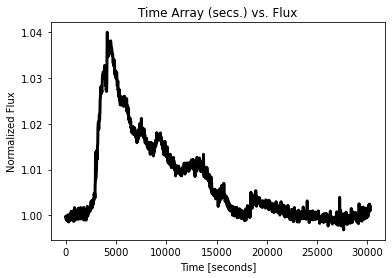

In [31]:
plt.plot(t1, flux_array1, linestyle = 'solid', linewidth = 3.0, color = 'black', label = "TESS 20s data")

plt.xlabel('Time [seconds]')
plt.ylabel('Normalized Flux')
plt.title('Time Array (secs.) vs. Flux')

Text(0.5, 1.0, 'Time Array (BTJD) vs. Flux')

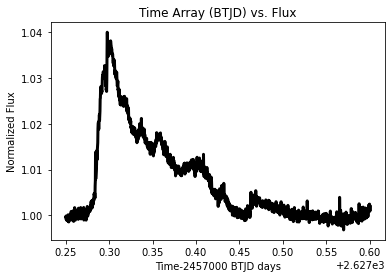

In [32]:
plt.plot(TESS_TIME, flux_array1, linestyle = 'solid', linewidth = 3.0, color = 'black', label = "TESS 20s data")

plt.xlabel('Time-2457000 BTJD days')
plt.ylabel('Normalized Flux')
plt.title('Time Array (BTJD) vs. Flux')

### **Step 9:** To define the analysis region, define the time and flux arrays.

In [177]:
timef1_AR = TESS_TIME[260 : 1295] # between 2627.3 - 2627.56 (analysis region) - whole range is from 0 - 1515

fluxf1_AR = flux_array1[260 : 1295] # same as time

# Checks
print('timef1.size:', timef1_AR.size) 
print('fluxf1.size:', fluxf1_AR.size) # SIZE = 1035

timef1.size: 1035
fluxf1.size: 1035


### **Step 10:** Define a new time array that starts at 0 seconds and plot the subsequent analysis region for the QPP.

In [25]:
tf1 = np.arange(start = 0, stop = 20700, step = 20, dtype = int)  # stop = 1035 * 20

# Checks
print('tf1.SIZE:', tf1.size)  
print('tf1[1]:', tf1[1])  
print('TYPE(tf1):', type(tf1))
print('tf1:', tf1)

tf1.SIZE: 1035
tf1[1]: 20
TYPE(tf1): <class 'numpy.ndarray'>
tf1: [    0    20    40 ... 20640 20660 20680]


Text(0, 0.5, 'Normalized Flux')

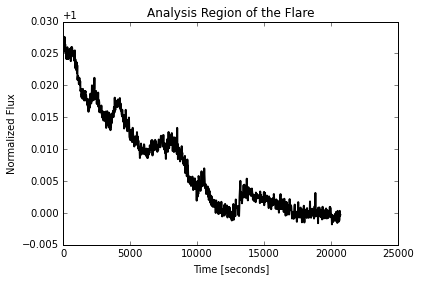

In [64]:
# FONT definition
imfont = {'family': 'serif',
        'color':  'blue',
        'weight': 'bold',
        'size': 16,
        }

plt.plot(tf1, fluxf1_AR, linestyle = 'solid', linewidth = 2.0, color = 'black', label = "TESS 20s data")

plt.title('Analysis Region of the Flare')
plt.xlabel('Time [seconds]')
plt.ylabel('Normalized Flux')

### **Step 11:** To highlight the analysis region, plot the entire flare and isolate the QPP.

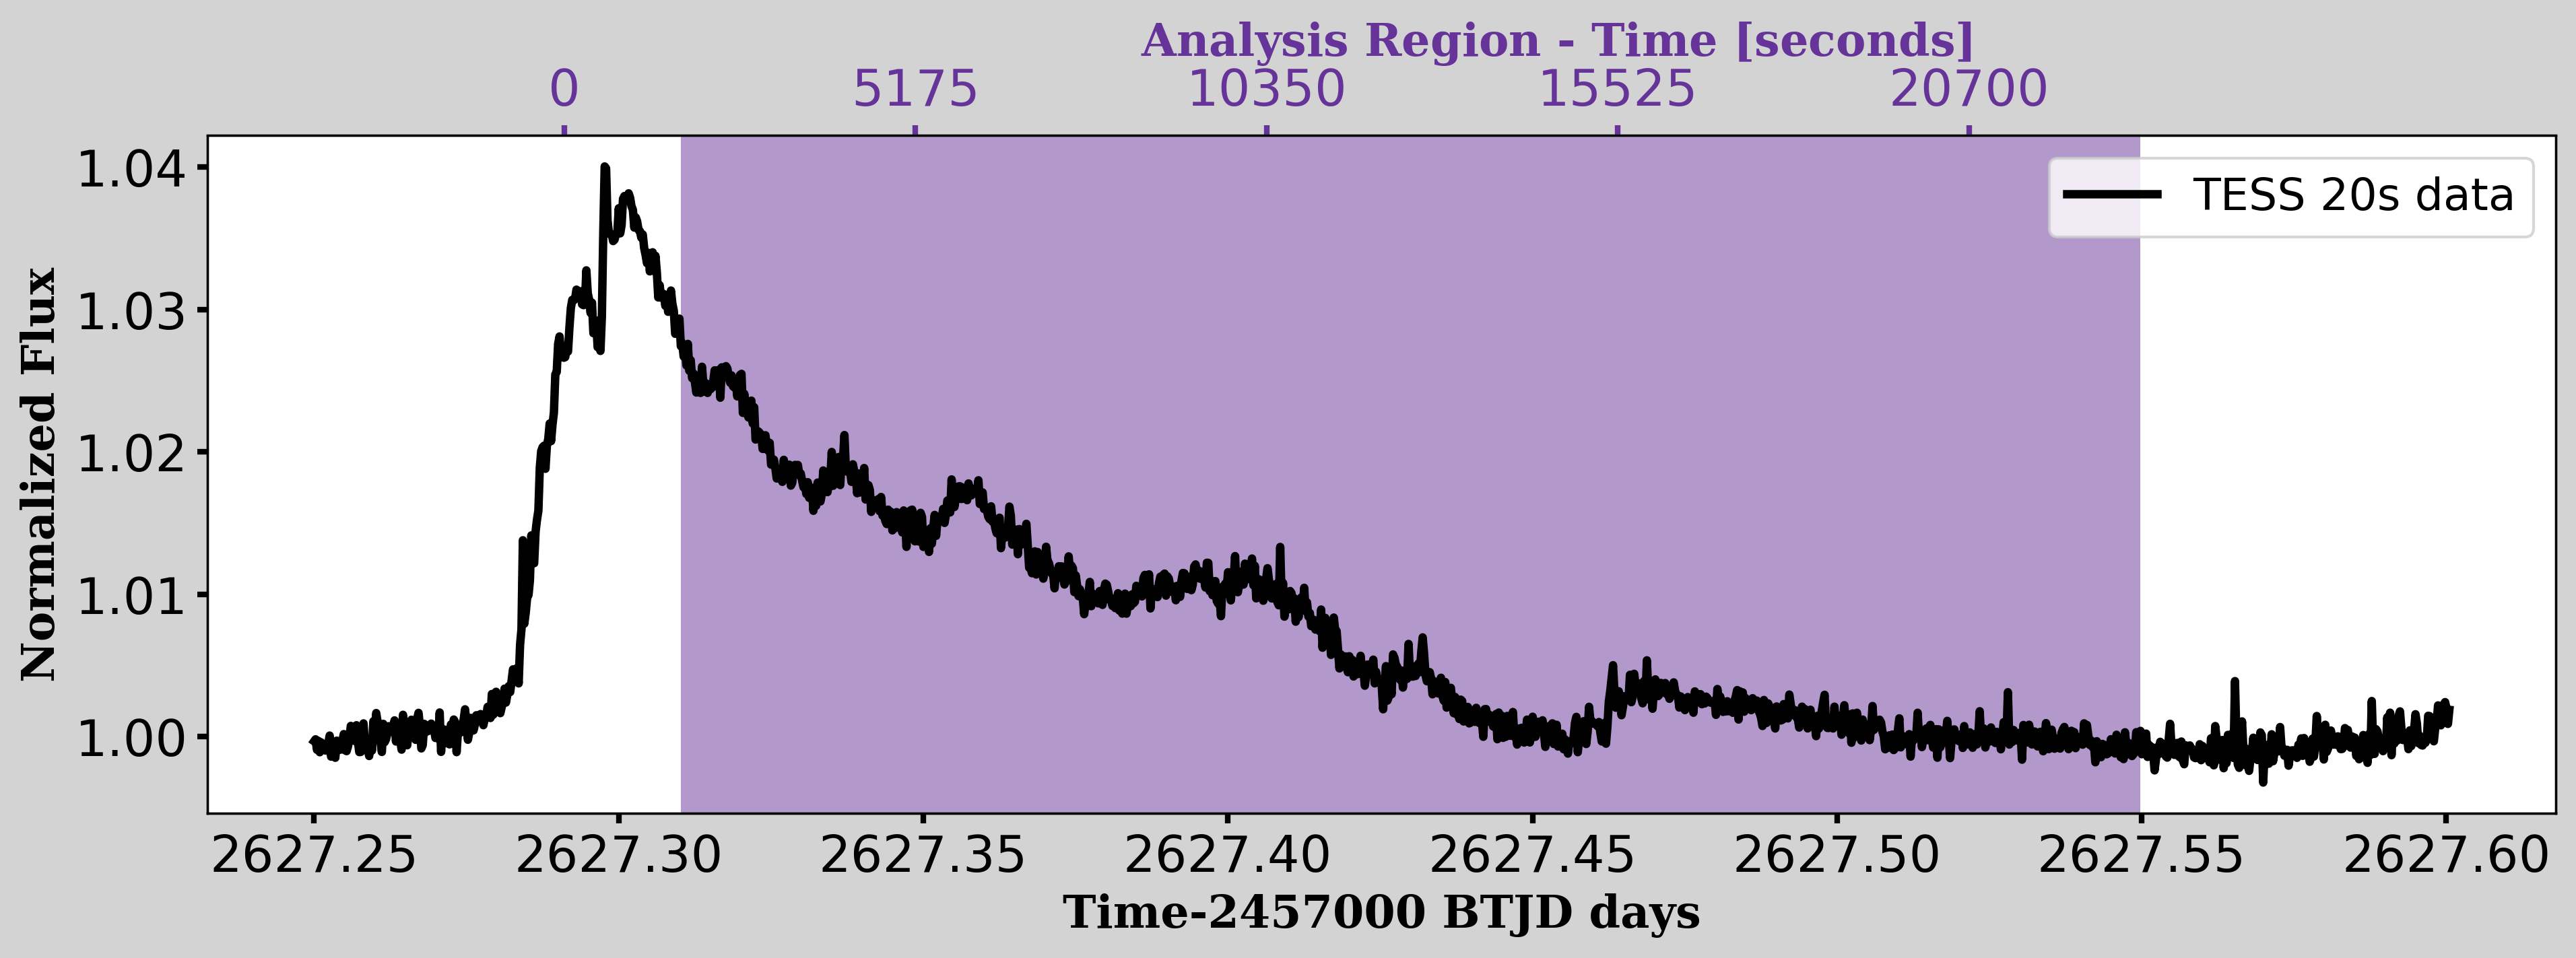

In [35]:
# FONT definition
fonta = {'family': 'serif',
        'color':  'rebeccapurple',
        'weight': 'bold',
        'size': 16,
        }

fontb = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

# #-----------------NEXT SECTION: PLOTS --------------------#
# #---------------------------------------------------------#
# # # define plot size in inches (width, height) & resolution(DPI)
fig = plt.figure(figsize = (15, 16), dpi = 300)  # x = 12 originally
ax = plt.gca() 
# fig.subplots_adjust(wspace = 0.20, hspace = 0.35)
fig.subplots_adjust(wspace = 0, hspace = 0.30)
fig.set_facecolor('lightgray')

# # ##------------------------------------------------------------------------#
# # ## PLOT - Flare 1
# # ##------------------------------------------------------------------------#
ax2 = plt.subplot(3, 1, 2)  # plt.subplot(#rows, #columns, index)
ax2.xaxis.set_tick_params(labelsize = 18, width = 2)
ax2.yaxis.set_tick_params(labelsize = 18, width = 2)
ax2.ticklabel_format(useOffset = False, style = 'plain')  # TURN OFF EXPONENTIAL
plt.ticklabel_format(style = 'sci', axis = 'y')

plt.plot(TESS_TIME, flux_array1, linestyle = 'solid', linewidth = 3.0, color = 'black', label = "TESS 20s data")
plt.xlabel('Time-2457000 BTJD days', fontdict = fontb)
plt.ylabel('Normalized Flux', fontdict = fontb)

# ##--LEGEND--##
plt.legend(loc = "upper right", prop = {'size': 16})  # LEGEND
# ##----------##

# # # ##------------------------------------------------------------------------#
# # # ## SHADING(DETRENDING RANGE): Flare 1
# # # ##------------------------------------------------------------------------#
f1a = TESS_TIME[260]
f1b = TESS_TIME[1295]

# plt.axvline(f1a, color = 'gray')
# plt.axvspan(f1a, f1b, facecolor = 'lightsteelblue', alpha = 0.5, lw = 2)  # SHADED AREAS (Detrend range)
plt.axvspan(f1a, f1b, facecolor = 'rebeccapurple', alpha = 0.5, lw = 2)  # SHADED AREAS (Detrend range)
# # # ##------------------------------------------------------------------------#

# ##----------##
##  SECOND AXIS - Custom axis for Analysis Region
# ##----------##
ax2a = ax2.twiny()
ax2a.xaxis.set_tick_params(labelsize = 18, width = 2)
ax2a.tick_params(axis = "x", colors = "rebeccapurple")
ax2a.set_xlabel(r'$\qquad \qquad \qquad \qquad$'"Analysis Region - Time [seconds]", fontdict = fonta)   
ax2a.set_xlim(0, 500)
# ax2a.set_xticks([101, 178.5, 256, 333.5, 411])  # X-TICKS value of 77.5 for each quarter section
ax2a.set_xticks([76, 150.75, 225.5, 300.25, 375])  # X-TICKS value of 74.75 for each quarter section
ax2a.set_xticklabels(['0', '5175' , '10350' , '15525' , '20700']) # X-TICKS VALUES - start from 0 to tf1 stop value, divide stop value by 4 to get middle ticks
# ##----------##

# # # ##------------------------------------------------------------------------#
plt.show()
# # # ##------------------------------------------------------------------------#

From here, it can be determined that this is a long-duration flare, about ~5.75 hours long. Flares usually have a rapid rise and then decay, but the QPPS are the oscillations that occur _after_ the main decay.

In [111]:
tf1_AR = np.arange(start = 0, stop = 20700, step = 20, dtype = int)  # stop = 1035 * 20

Text(0, 0.5, 'Flux [electrons / s]')

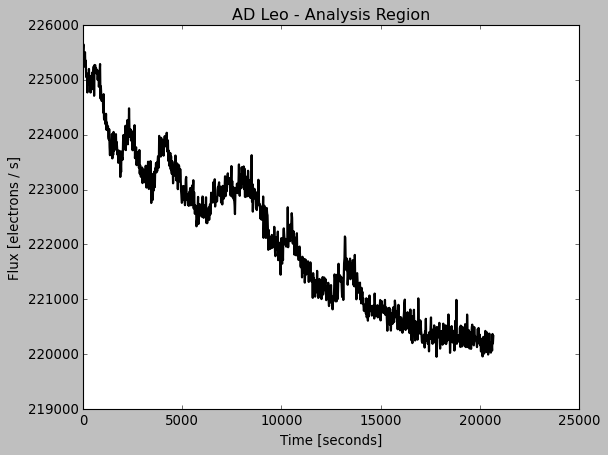

In [112]:
# FONT definition
imfont = {'family': 'serif',
        'color':  'blue',
        'weight': 'bold',
        'size': 16,
        }

plt.plot(tf1_AR, fluxf1_AR, linestyle = 'solid', linewidth = 2.0, color = 'black', label = "TESS 20s data")

plt.title('AD Leo - Analysis Region')
plt.xlabel('Time [seconds]')
plt.ylabel('Flux [electrons / s]')

### **Step 12:** Detrend and smooth the flare using the Savitzky-Golay method.

In [113]:
# ##------------------------------------------------------------------------#
# ##  APPLYING SAVITSKY-GOLAY FILTER
# ##------------------------------------------------------------------------#

# ## apply SavGol filter (Window=41, polyorder=4)
smooth_data_savgol = savgol_filter(fluxf1_AR, window_length=11, polyorder=4)
print('smooth_data_savgol.size:', smooth_data_savgol.size)  #Checks
#print('smooth_data_savgol:',smooth_data_savgol)  #Checks

# ##------------------------------------------------------------------------#
# ##  DETREND THE SMOOTH DATA
# ##------------------------------------------------------------------------#
detrend_flux = signal.detrend(smooth_data_savgol)
print('detrend_flux.size:', detrend_flux.size)  #Checks

smooth_data_savgol.size: 1035
detrend_flux.size: 1035


In [114]:
plt.style.use('classic')

#CREATING A DICTIONARY TO DEFINE FONTS

font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 15,   #10 before
        }
fonta = {'family': 'serif',
        'color':  'blue',
        'weight': 'bold',
        'size': 15,   #10 before
        }


font2 = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 10,
        }

imfont = {'family': 'serif',
        'color':  'blue',
        'weight': 'bold',
        'size': 16,
        }

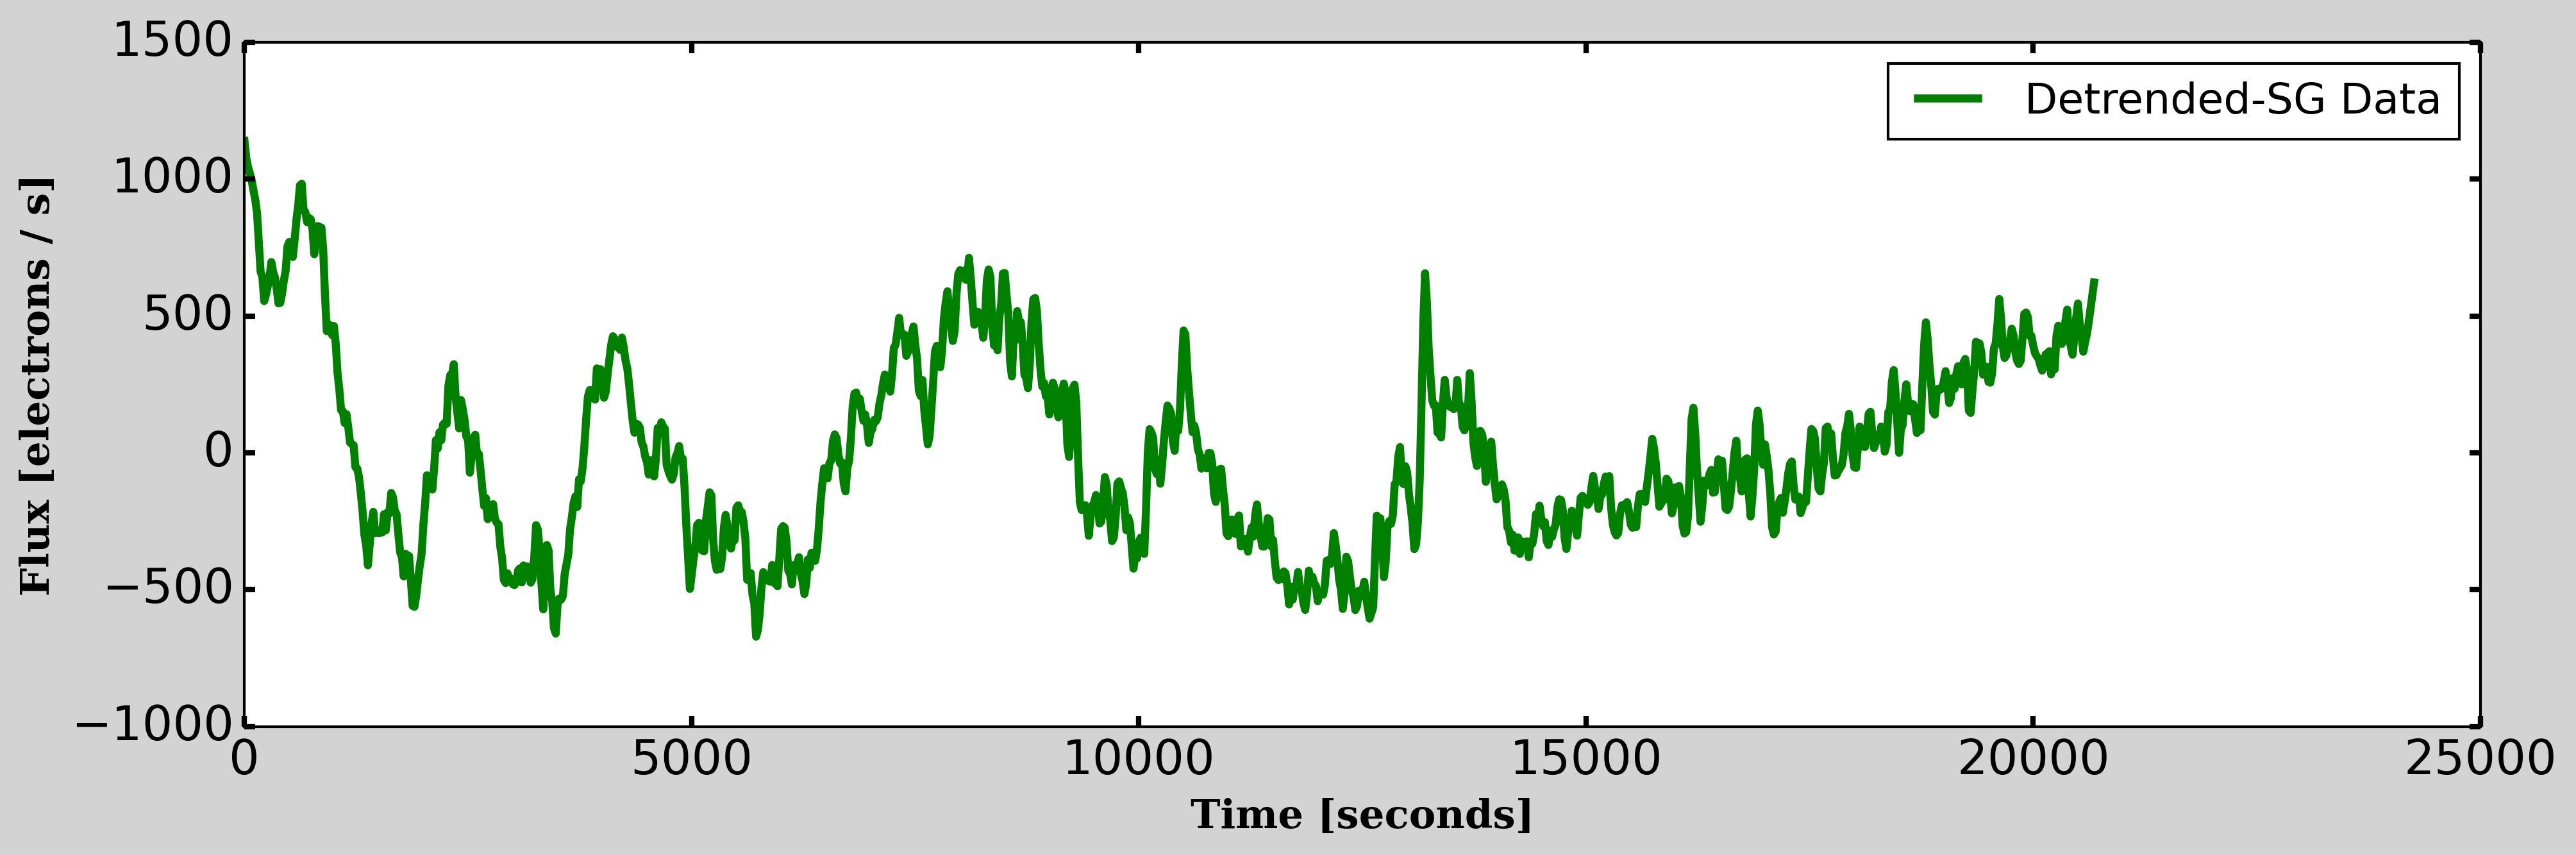

In [115]:
# #-----------------NEXT SECTION: PLOTS --------------------#
# #---------------------------------------------------------#
# # #define plot size in inches (width, height) & resolution(DPI)
fig = plt.figure(figsize=(15,16), dpi=300)  #x=12 originally
ax = plt.gca() 
#fig.subplots_adjust(wspace=0.20, hspace=0.35)
fig.subplots_adjust(wspace=0, hspace=0.30)
fig.set_facecolor('lightgray')


# # ##------------------------------------------------------------------------#
# # ## PLOT - ROSS 614 two flares 
# # ##------------------------------------------------------------------------#
ax1=plt.subplot(3,1,1)  #plt.subplot(#rows,#columns,index)
ax1.xaxis.set_tick_params(labelsize=18, width=2)
ax1.yaxis.set_tick_params(labelsize=18, width=2)
ax1.ticklabel_format(useOffset=False, style='plain')  # TURN OFF EXPONENTIAL
plt.ticklabel_format(style='sci', axis='y')


plt.plot(tf1_AR, detrend_flux, linestyle='solid', linewidth=3.0, color='green', label="Detrended-SG Data")
# plt.plot(tf1, smooth_data_savgol, linestyle='dashed', linewidth=3.0, color='blue', label="SG_Filter")
# plt.plot(tf1, fluxf1_AR, linestyle='solid', linewidth=2.0, color='black', label="F1 TESS 20s data")


plt.xlabel('Time [seconds]',fontdict=font)
plt.ylabel('Flux [electrons / s]',fontdict=font)

# # # ##--LEGEND--##
plt.legend(loc="upper right",prop={'size': 16})  #LEGEND
# # # ##----------##

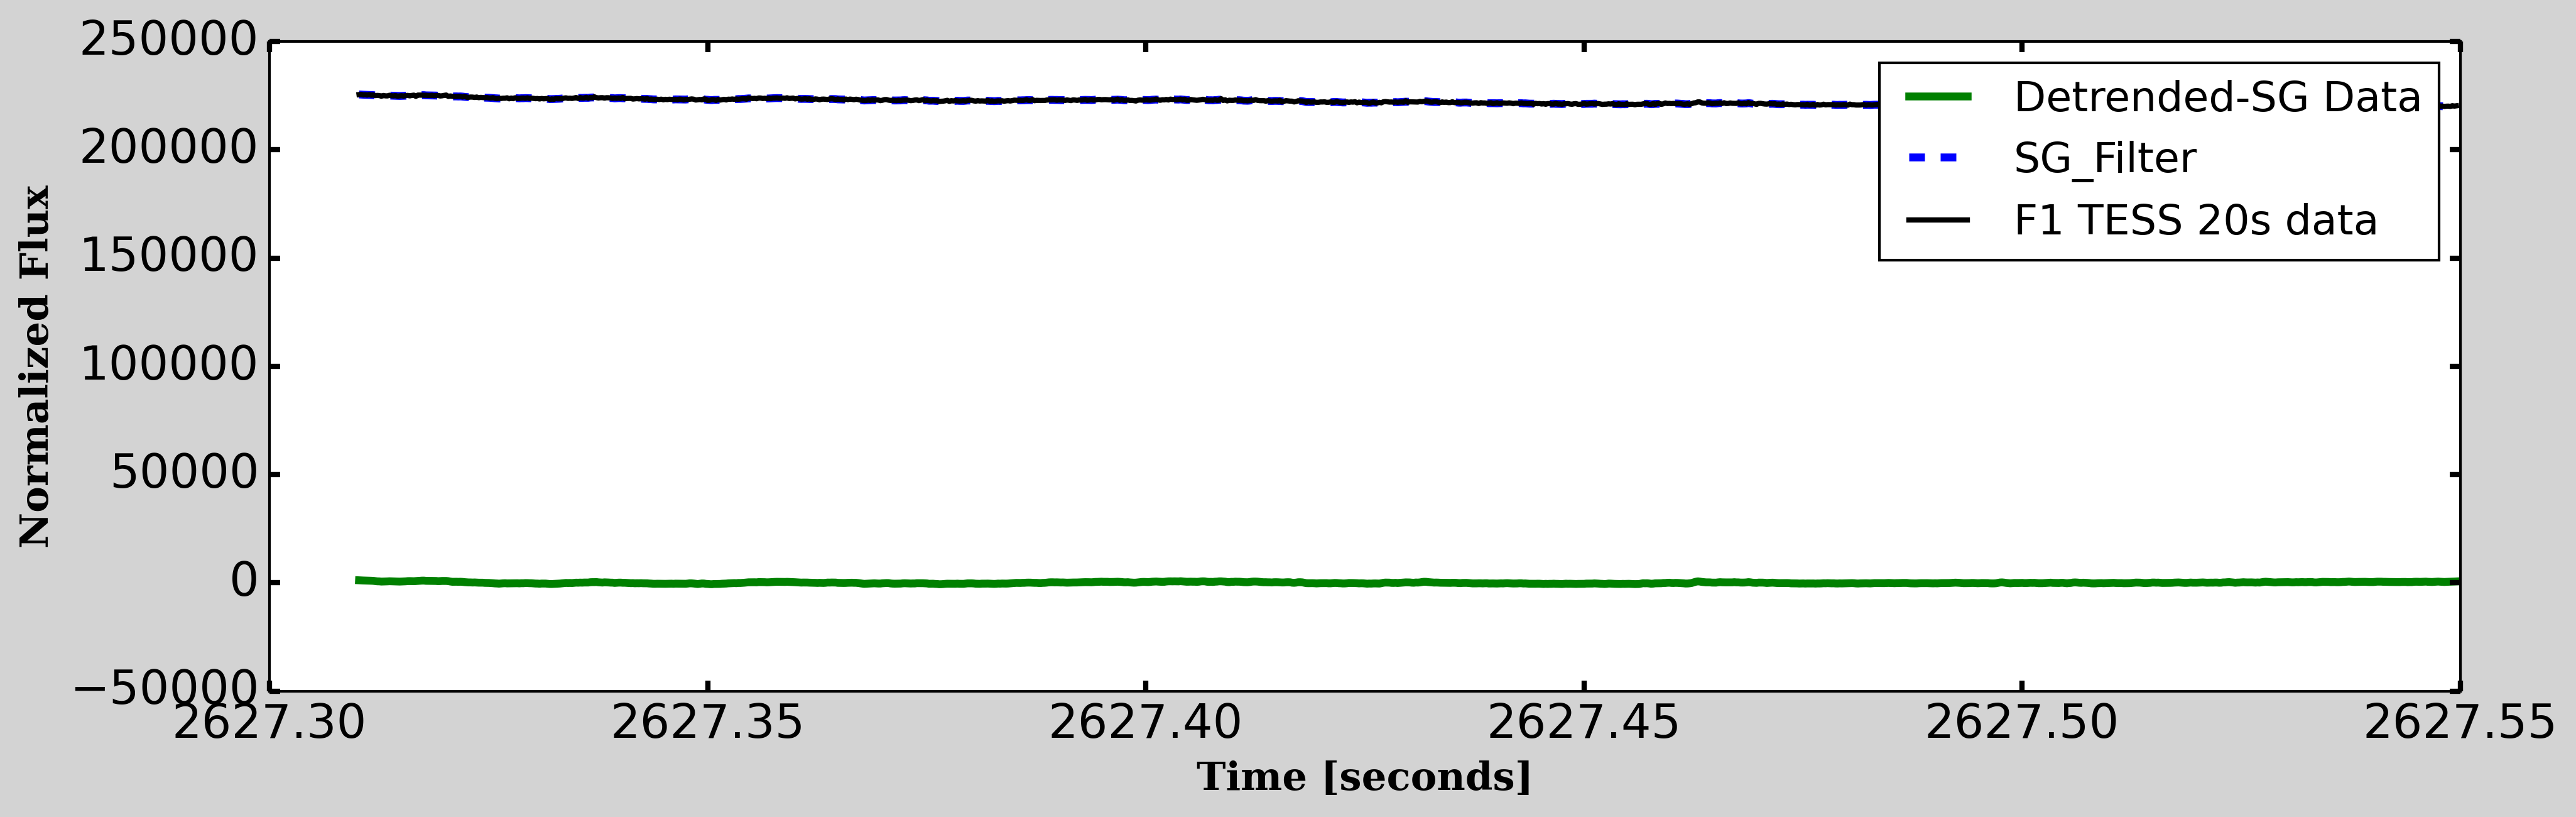

In [130]:
# #-----------------NEXT SECTION: PLOTS --------------------#
# #---------------------------------------------------------#
# # #define plot size in inches (width, height) & resolution(DPI)
fig = plt.figure(figsize=(15,16), dpi=300)  #x=12 originally
ax = plt.gca() 
#fig.subplots_adjust(wspace=0.20, hspace=0.35)
fig.subplots_adjust(wspace=0, hspace=0.30)
fig.set_facecolor('lightgray')


# # ##------------------------------------------------------------------------#
# # ## PLOT - ROSS 614 two flares 
# # ##------------------------------------------------------------------------#
ax1=plt.subplot(3,1,1)  #plt.subplot(#rows,#columns,index)
ax1.xaxis.set_tick_params(labelsize=18, width=2)
ax1.yaxis.set_tick_params(labelsize=18, width=2)
ax1.ticklabel_format(useOffset=False, style='plain')  # TURN OFF EXPONENTIAL
plt.ticklabel_format(style='sci', axis='y')


plt.plot(timef1_AR, detrend_flux, linestyle='solid', linewidth=3.0, color='green', label="Detrended-SG Data")
plt.plot(timef1_AR, smooth_data_savgol, linestyle='dashed', linewidth=3.0, color='blue', label="SG_Filter")
plt.plot(timef1_AR, fluxf1_AR, linestyle='solid', linewidth=2.0, color='black', label="F1 TESS 20s data")


plt.xlabel('Time [seconds]',fontdict=font)
plt.ylabel('Normalized Flux',fontdict=font)

# # # ##--LEGEND--##
plt.legend(loc="upper right",prop={'size': 16})  #LEGEND
# # # ##----------##

For small fluxes, there will be a domain error due to this seemingly flat line.

### **Step 13:** To decompose the signal to its fundamental oscillations, use the Empirical Mode Decomposition (EMD) method.

EMD decomposes a signal into its fundamental oscillations by sifting the signal. This allows the EMD creates an envelope above and below the signal and takes the average of the envelopes. The average of the envelopes is called an Intrinsic Mode Function (IMF).

In [175]:
imf = emd.sift.sift(detrend_flux)
print(imf.shape)

(1035, 7)


/Users/maniktuladhar/opt/anaconda3/lib/python3.8/site-packages/emd/plotting.py:130: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


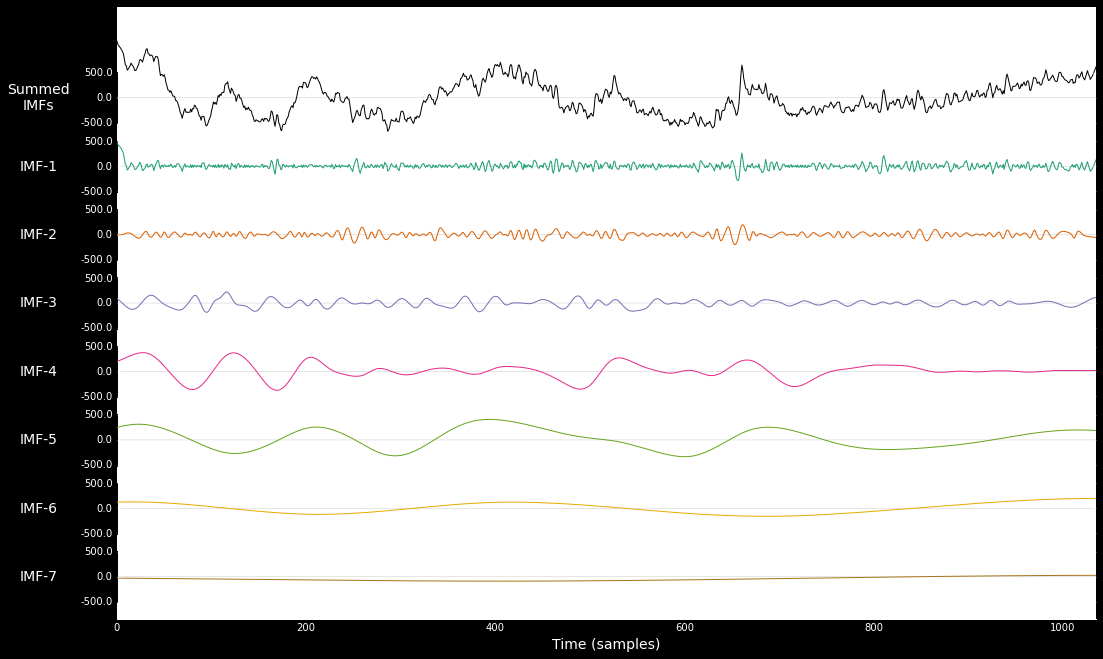

In [176]:
plt.style.use('dark_background')
emd.plotting.plot_imfs(imf).set_facecolor('white')

### **Conclusions:**

**Current status:** Find the IMFs in the EMD method to help with modeling the QPP oscillations in the AD Leo flare.

**Future steps:** Create a custom fit model on the oscillations using the IMFs. This will optimize the analysis region to hone in on the oscillations within the flare.

This concludes the notebook used to create the plots presented during the online Code 600 intern final presentations online for NASA GSFC. Thank you!